In [1]:
!pip install opencv-contrib-python
!pip install requests

In [15]:
import numpy as np
import platform
from PIL import ImageFont, ImageDraw, Image
from matplotlib import pyplot as pyplot
import matplotlib.pyplot as plt

import uuid
import json
import time
import cv2
import requests


In [3]:
# Jupyter Notebook 또는 Colab에서 이미지를 확인하기위한 Function

def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)

    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []

            for i in range(len(img)):
                titles.append(title)

        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)

            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])

        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

In [4]:
# OpenCV의  putText 를 이용하여 한글을 출력하는 경우 한글이 깨지는 문제를 해결하기 위한 Funtion

def put_text(image, text, x, y, color=(0, 255, 0), font_size=22):
    if type(image) == np.ndarray:
        color_coverted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(color_coverted)

    if platform.system() == 'Darwin':
        font = 'AppleGothic.ttf'
    elif platform.system() == 'Windows':
        font = 'malgun.ttf'

    image_font = ImageFont.truetype(font, font_size)
    font = ImageFont.load_default()
    draw = ImageDraw.Draw(image)

    draw.text((x, y), text, font=image_font, fill=color)

    numpy_image = np.array(image)
    opencv_image = cv2.cvtColor(numpy_image, cv2.COLOR_RGB2BGR)

    return opencv_image

In [5]:
api_url = ''
secret_key = ''

In [6]:
# 이미지 바이너리로 변환하여 로드
path = 'test_1.jpg'
files = [('file', open(path,'rb'))]

In [7]:
# Request to CLOVA OCR API

request_json = {'images': [{'format': 'jpg',
                                'name': 'demo'
                               }],
                    'requestId': str(uuid.uuid4()),
                    'version': 'V2',
                    'timestamp': int(round(time.time() * 1000))
                   }

payload = {'message': json.dumps(request_json).encode('UTF-8')}

headers = {
  'X-OCR-SECRET': secret_key,
}

response = requests.request("POST", api_url, headers=headers, data=payload, files=files)
result = response.json()

In [11]:
def put_text(image, text, x, y, color=(0, 255, 0), font_size=30, font_path='malgun.ttf'):  # 폰트 경로를 매개변수로 추가
    image_font = ImageFont.truetype(font_path, font_size)
    draw = ImageDraw.Draw(image)
    draw.text((x, y), text, fill=color, font=image_font)

20
을지로1길
Eulji-ro
~32116
1-gil
16
9길
46
9-gil
Namuuemun-ro
50
| →


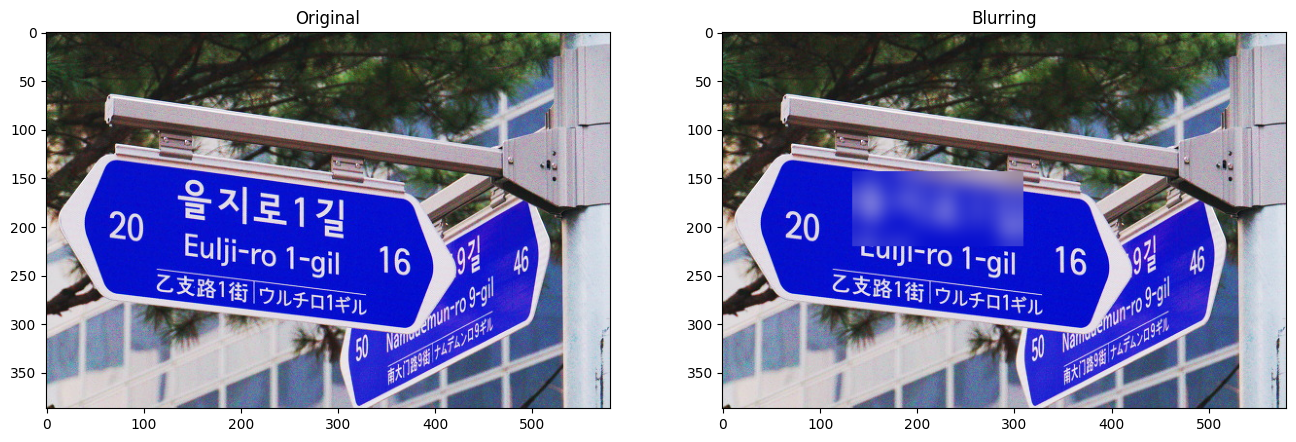

In [20]:
# 결과 확인

img = cv2.imread(path)
roi_img = img.copy()
original = img.copy()


# 블러링 적용할 글자 목록 설정
text_to_blur = ["을지로1길"]

for field in result['images'][0]['fields']:
    text = field['inferText']
    vertices_list = field['boundingPoly']['vertices']
    pts = [tuple(vertice.values()) for vertice in vertices_list]
    topLeft = [int(_) for _ in pts[0]]
    topRight = [int(_) for _ in pts[1]]
    bottomRight = [int(_) for _ in pts[2]]
    bottomLeft = [int(_) for _ in pts[3]]

    cv2.line(roi_img, topLeft, topRight, (0,255,0), 2)
    cv2.line(roi_img, topRight, bottomRight, (0,255,0), 2)
    cv2.line(roi_img, bottomRight, bottomLeft, (0,255,0), 2)
    cv2.line(roi_img, bottomLeft, topLeft, (0,255,0), 2)

    # 기본 폰트 사용
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_color = (0, 255, 0)
    font_thickness = 2
    text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
    text_x = topLeft[0]
    text_y = topLeft[1] - 10

    cv2.putText(roi_img, text, (text_x, text_y), font, font_scale, font_color, font_thickness, lineType=cv2.LINE_AA)

    print(text)

   # 블러링 적용
    if text in text_to_blur:
        x1, y1 = topLeft
        x2, y2 = bottomRight
        roi = img[y1:y2, x1:x2]
        roi = cv2.GaussianBlur(roi, (0, 0), sigmaX=10)  # 블러링 효과 적용
        img[y1:y2, x1:x2] = roi

# 이미지 표시
plt.figure(figsize=(16, 10))
plt.subplot(121)
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.title("Original")
plt.subplot(122)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Blurring")
plt.show()